In [88]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
trjtpr11='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-5/cnt.tpr'
trjtpr12='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-6/cnt.tpr'
trjtpr13='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-7/cnt.tpr'
trjtpr14='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-8/cnt.tpr'
trjtpr15='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-9/cnt.tpr'
trjxtc11='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-5/6-6-5.xtc'
trjxtc12='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-6/6-6-6.xtc'
trjxtc13='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-7/6-6-7.xtc'
trjxtc14='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-8/6-6-8.xtc'
trjxtc5='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-9/6-6-9.xtc'
u11 = mda.Universe(trjtpr1,trjxtc1)
u12 = mda.Universe(trjtpr2,trjxtc2)
u13 = mda.Universe(trjtpr3,trjxtc3)
u14 = mda.Universe(trjtpr4,trjxtc4)
u15 = mda.Universe(trjtpr5,trjxtc5)

In [47]:
trjtpr1='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-5/cnt.tpr'
trjtpr2='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-6/cnt.tpr'
trjtpr3='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-7/cnt.tpr'
trjtpr4='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-8/cnt.tpr'
trjtpr5='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-9/cnt.tpr'
trjxtc1='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-5/6-6-5.xtc'
trjxtc2='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-6/6-6-6.xtc'
trjxtc3='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-7/6-6-7.xtc'
trjxtc4='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-8/6-6-8.xtc'
trjxtc5='/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-9/6-6-9.xtc'
u1 = mda.Universe(trjtpr1,trjxtc1)
u2 = mda.Universe(trjtpr2,trjxtc2)
u3 = mda.Universe(trjtpr3,trjxtc3)
u4 = mda.Universe(trjtpr4,trjxtc4)
u5 = mda.Universe(trjtpr5,trjxtc5)

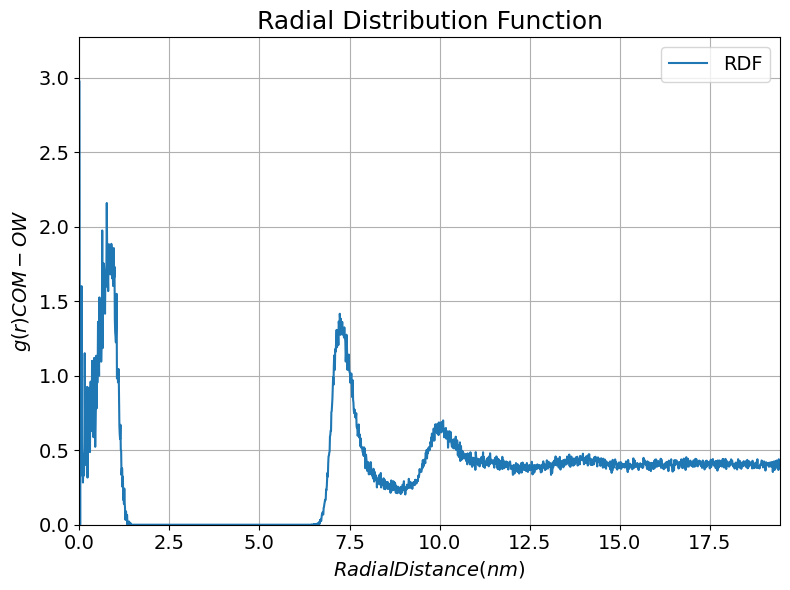

In [9]:
# 读入轨迹
# u = mda.Universe('topology_file', 'trajectory_file')

# 获取相关原子组
o_atoms = u.select_atoms('type OT')
cnt_c_atoms = u.select_atoms('resname CNT and name C')

# 计算CNT C原子的z坐标平均值
z_mean = cnt_c_atoms.positions[:,2].mean()
cnt_up_h_atoms = u.select_atoms(f'resname CNT and name H and prop z > {z_mean}')
cnt_down_h_atoms = u.select_atoms(f'resname CNT and name H and prop z <= {z_mean}')

# 计算上下两组H原子的z坐标平均值并做微调
z_up = cnt_up_h_atoms.positions[:,2].mean() - 2
z_down = cnt_down_h_atoms.positions[:,2].mean() + 2

# 初始化用于计算rho_0的变量
total_o_atoms_outside = 0
total_volume_outside = 0
radius_reference = 15.5

# 随机选择100帧
num_frames = len(u.trajectory)
selected_frames = random.sample(range(num_frames), 100)

for frame_index in selected_frames:
    ts = u.trajectory[frame_index]
    
    # 获取当前帧的氧原子位置
    o_positions = o_atoms.positions
    cog = (cnt_up_h_atoms.center_of_geometry() + cnt_down_h_atoms.center_of_geometry()) / 2
    distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)
    
    # 计算大于radius_reference处的原子的数量
    mask_outside = distances > radius_reference
    total_o_atoms_outside += np.sum(mask_outside)
    
    # 计算大于radius_reference处的体积
    total_volume_outside += (u.dimensions[0] * u.dimensions[1] * (u.dimensions[2] - 2*radius_reference))

# 计算rho_0 (3D)
rho_0 = total_o_atoms_outside / total_volume_outside

# 初始化径向分布函数的数组和相关参数
n_bins = 2000
radial_max = min(u.dimensions[0]/2, u.dimensions[1]/2)
bin_edges = np.linspace(0, radial_max, n_bins+1)
bin_width = bin_edges[1] - bin_edges[0]
bin_centers = bin_edges[:-1] + bin_width / 2
rdf_sum = np.zeros(n_bins)
frames_counted = 0

for ts in u.trajectory[500:2500]:
    # 对于每一帧计算rdf
    o_positions = o_atoms.positions
    z_o_positions = o_positions[:, 2]
    mask = (z_o_positions > z_down) & (z_o_positions < z_up)
    o_positions = o_positions[mask]
    distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)
    
    # 使用np.histogram()来计算这一帧的rdf
    counts, bin_edges = np.histogram(distances, bins=bin_edges, density=False)
    
    # 累加
    rdf_sum += counts
    frames_counted += 1

# 重新计算理想情况下的原子数
ideal_counts = 2 * np.pi * bin_centers * bin_width * rho_0
rdf_mean = rdf_sum / (frames_counted * ideal_counts)

plt.figure(figsize=(8, 6))
plt.plot(bin_centers, rdf_mean*0.1, '-', label="RDF")
plt.xlabel("$Radial Distance (nm)$", fontsize=14)
plt.ylabel("$g(r) COM-OW$", fontsize=14)
plt.title("Radial Distribution Function", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, radial_max)
plt.ylim(0, max(rdf_mean)*1.1*0.1)
plt.tight_layout()
plt.show()


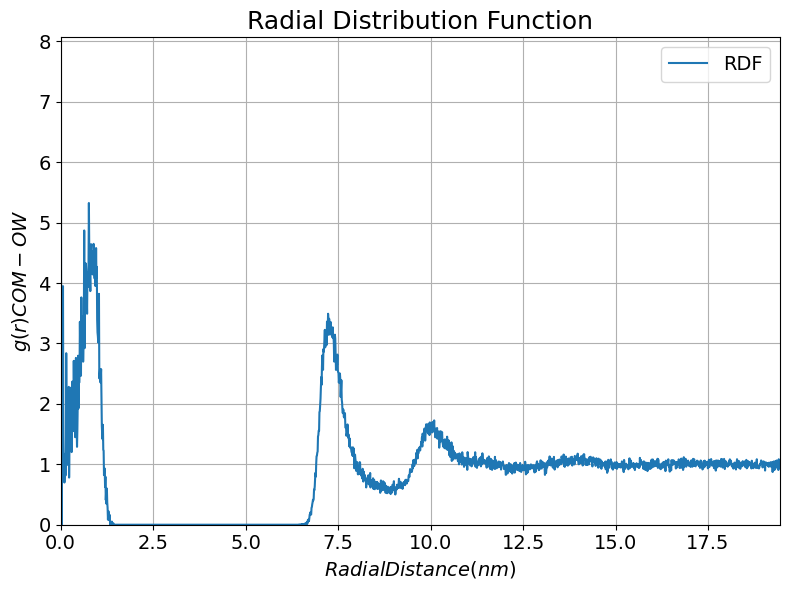

In [10]:
# 在计算rdf_mean之后

# 计算最远端（例如最后10%）的平均值
tail_fraction = 0.1
tail_start = int((1 - tail_fraction) * len(rdf_mean))
tail_mean = np.mean(rdf_mean[tail_start:])

# 使用该平均值对整个RDF进行归一化
rdf_normalized = rdf_mean / tail_mean

plt.figure(figsize=(8, 6))
plt.plot(bin_centers, rdf_normalized, '-', label="RDF")
plt.xlabel("$Radial Distance (nm)$", fontsize=14)
plt.ylabel("$g(r) COM-OW$", fontsize=14)
plt.title("Radial Distribution Function", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, radial_max)
plt.ylim(0, max(rdf_normalized)*1.1)
plt.tight_layout()
plt.show()


/tmp/ipykernel_74996/4044916146.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('rainbow_r',len(u_list)+1)


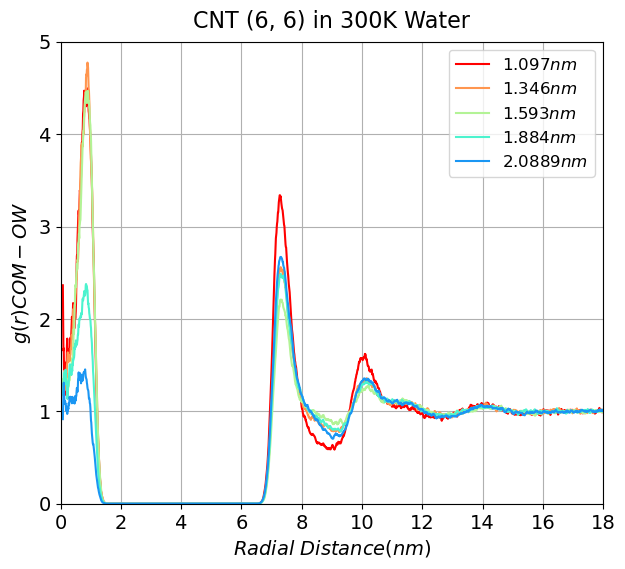

In [87]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

def compute_normalized_rdf(u):
    # 获取相关原子组
    o_atoms = u.select_atoms('type OT')
    cnt_c_atoms = u.select_atoms('resname CNT and name C')

    # 计算CNT C原子的z坐标平均值
    z_mean = cnt_c_atoms.positions[:,2].mean()
    cnt_up_h_atoms = u.select_atoms(f'resname CNT and name H and prop z > {z_mean}')
    cnt_down_h_atoms = u.select_atoms(f'resname CNT and name H and prop z <= {z_mean}')

    # 计算上下两组H原子的z坐标平均值并做微调
    z_up = cnt_up_h_atoms.positions[:,2].mean() - 2
    z_down = cnt_down_h_atoms.positions[:,2].mean() + 2

    # 初始化用于计算rho_0的变量
    total_o_atoms_outside = 0
    total_volume_outside = 0
    radius_reference = 15.5

    # 随机选择100帧
    num_frames = len(u.trajectory)
    selected_frames = random.sample(range(num_frames), 100)

    for frame_index in selected_frames:
        ts = u.trajectory[frame_index]

        # 获取当前帧的氧原子位置
        o_positions = o_atoms.positions
        cog = (cnt_up_h_atoms.center_of_geometry() + cnt_down_h_atoms.center_of_geometry()) / 2
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 计算大于radius_reference处的原子的数量
        mask_outside = distances > radius_reference
        total_o_atoms_outside += np.sum(mask_outside)

        # 计算大于radius_reference处的体积
        total_volume_outside += (u.dimensions[0] * u.dimensions[1] * (u.dimensions[2] - 2*radius_reference))

    # 计算rho_0 (3D)
    rho_0 = total_o_atoms_outside / total_volume_outside

    # 初始化径向分布函数的数组和相关参数
    n_bins = 2000
    radial_max = min(u.dimensions[0]/2, u.dimensions[1]/2)
    bin_edges = np.linspace(0, radial_max, n_bins+1)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[:-1] + bin_width / 2
    rdf_sum = np.zeros(n_bins)
    frames_counted = 0

    for ts in u.trajectory[1:3000]:
        # 对于每一帧计算rdf
        o_positions = o_atoms.positions
        z_o_positions = o_positions[:, 2]
        mask = (z_o_positions > z_down) & (z_o_positions < z_up)
        o_positions = o_positions[mask]
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 使用np.histogram()来计算这一帧的rdf
        counts, _ = np.histogram(distances, bins=bin_edges, density=False)

        # 累加
        rdf_sum += counts
        frames_counted += 1

    # 重新计算理想情况下的原子数
    ideal_counts = 2 * np.pi * bin_centers * bin_width * rho_0
    rdf_mean = rdf_sum / (frames_counted * ideal_counts)

    # 归一化RDF
    tail_fraction = 0.1
    tail_start = int((1 - tail_fraction) * len(rdf_mean))
    tail_mean = np.mean(rdf_mean[tail_start:])
    rdf_normalized = rdf_mean / tail_mean

    return bin_centers, rdf_normalized

# 使用示例：
# 你可以传入多个`u`对象，如u1, u2等，然后使用以下代码绘制在同一张图上
u_list = [u1,u2,u3,u4,u5]  # 可以添加更多的u对象，例如: [u1, u2, u3,...]



def moving_average(data, window_size=10):
    """返回数据的滚动平均值。"""
    series = pd.Series(data)
    return series.rolling(window=window_size).mean().values

def plot_rdf(u_list, labels=None):
    """
    为每一个u对象绘制RDF图
    u_list: 包含u对象的列表
    labels: 与u_list相对应的标签列表，用于图例
    """
    plt.figure(figsize=(7, 6))
    
    # 获取color_map
    color_map = cm.get_cmap('rainbow_r',len(u_list)+1)
    
    for idx, u_obj in enumerate(u_list):
        bin_centers, rdf_normalized = compute_normalized_rdf(u_obj)
        rdf_smooth = moving_average(rdf_normalized, window_size=8)  # 这里设置窗口大小为50，你可以根据需求进行调整
        
        # 为每条曲线选择颜色
        color = color_map(idx)
        
        # 使用给定的标签或默认标签
        if labels:
            label = labels[idx]
        else:
            label = f"RDF for {u_obj}"
        
        plt.plot(bin_centers, rdf_smooth, '-', color=color, label=label)

    plt.xlabel("$Radial\ Distance (nm)$", fontsize=14)
    plt.ylabel("$g(r) COM-OW$", fontsize=14)
    plt.title("CNT (6, 6) in 300K Water", fontsize=16,pad=10)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0, radial_max)
    plt.ylim(0, 5)
    plt.yticks


labels = ["$1.097 nm$", "$1.346 nm$", "$1.593 nm$", "$1.884 nm$", "$2.0889 nm$"]
plot_rdf(u_list, labels=labels)
plt.savefig("rdf_plot.svg", format="svg", transparent=True)

# %%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%

# %%%%%%%%%%%%%%%%%%%%%%%%%%

### read

In [94]:
import MDAnalysis as mda

index = 1
for x in range(6, 13):  # x从6遍历到12
    for y in range(5, 10):  # y从5遍历到9
        trjtpr_var_name = f"trjtpr1_{index}"
        trjxtc_var_name = f"trjxtc1_{index}"
        u_var_name = f"u1_{index}"

        trjtpr_path = f"/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/{x}-{x}-{y}/cnt.tpr"
        trjxtc_path = f"/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/{x}-{x}-{y}/{x}-{x}-{y}.xtc"

        # 动态为每一个mda.Universe对象创建一个变量
        globals()[u_var_name] = mda.Universe(trjtpr_path, trjxtc_path)

        # 打印信息
        print(f"{trjtpr_var_name} = '{trjtpr_path}'")
        print(f"{trjxtc_var_name} = '{trjxtc_path}'")
        print(f"{u_var_name} = mda.Universe('{trjtpr_path}', '{trjxtc_path}')")
        print()

        index += 1


trjtpr1_1 = '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-5/cnt.tpr'
trjxtc1_1 = '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-5/6-6-5.xtc'
u1_1 = mda.Universe('/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-5/cnt.tpr', '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-5/6-6-5.xtc')

trjtpr1_2 = '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-6/cnt.tpr'
trjxtc1_2 = '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-6/6-6-6.xtc'
u1_2 = mda.Universe('/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-6/cnt.tpr', '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-6/6-6-6.xtc')

trjtpr1_3 = '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-7/cnt.tpr'
trjxtc1_3 = '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-7/6-6-7.xtc'
u1_3 = mda.Universe('/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-7/cnt.tpr', '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-7/6-6-7.xtc')

trjtpr1_4 = '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-8/cnt.tpr'
trjxtc1_4 = '/home/jxhe/works/toolkits/01-

trjtpr1_29 = '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/11-11-8/cnt.tpr'
trjxtc1_29 = '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/11-11-8/11-11-8.xtc'
u1_29 = mda.Universe('/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/11-11-8/cnt.tpr', '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/11-11-8/11-11-8.xtc')

trjtpr1_30 = '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/11-11-9/cnt.tpr'
trjxtc1_30 = '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/11-11-9/11-11-9.xtc'
u1_30 = mda.Universe('/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/11-11-9/cnt.tpr', '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/11-11-9/11-11-9.xtc')

trjtpr1_31 = '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/12-12-5/cnt.tpr'
trjxtc1_31 = '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/12-12-5/12-12-5.xtc'
u1_31 = mda.Universe('/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/12-12-5/cnt.tpr', '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/12-12-5/12-12-5.xtc')

trjtpr1_32 = '/home/jxhe/works/toolkits/01-fixdp-6-12-6-19/12-12-6/cnt

In [96]:
u1_1.trajectory

<XTCReader /home/jxhe/works/toolkits/01-fixdp-6-12-6-19/6-6-5/6-6-5.xtc with 3762 frames of 5718 atoms>

### whole

/tmp/ipykernel_74996/3263263633.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('rainbow_r',len(u_list)+1)


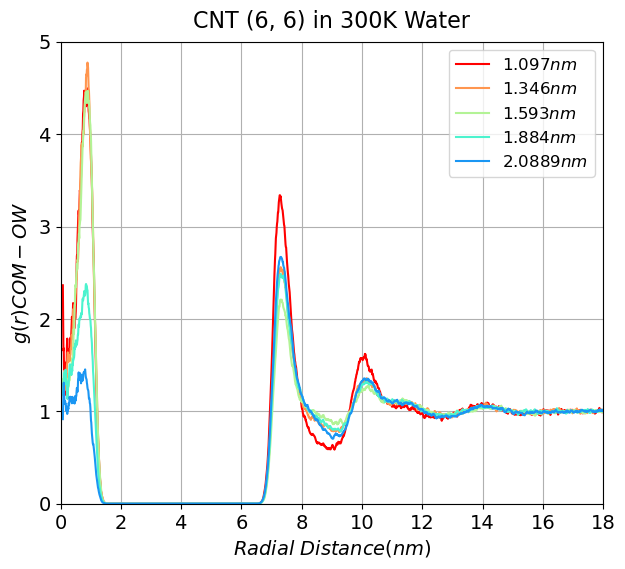

In [97]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

def compute_normalized_rdf(u):
    # 获取相关原子组
    o_atoms = u.select_atoms('type OT')
    cnt_c_atoms = u.select_atoms('resname CNT and name C')

    # 计算CNT C原子的z坐标平均值
    z_mean = cnt_c_atoms.positions[:,2].mean()
    cnt_up_h_atoms = u.select_atoms(f'resname CNT and name H and prop z > {z_mean}')
    cnt_down_h_atoms = u.select_atoms(f'resname CNT and name H and prop z <= {z_mean}')

    # 计算上下两组H原子的z坐标平均值并做微调
    z_up = cnt_up_h_atoms.positions[:,2].mean() - 2
    z_down = cnt_down_h_atoms.positions[:,2].mean() + 2

    # 初始化用于计算rho_0的变量
    total_o_atoms_outside = 0
    total_volume_outside = 0
    radius_reference = 15.5

    # 随机选择100帧
    num_frames = len(u.trajectory)
    selected_frames = random.sample(range(num_frames), 100)

    for frame_index in selected_frames:
        ts = u.trajectory[frame_index]

        # 获取当前帧的氧原子位置
        o_positions = o_atoms.positions
        cog = (cnt_up_h_atoms.center_of_geometry() + cnt_down_h_atoms.center_of_geometry()) / 2
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 计算大于radius_reference处的原子的数量
        mask_outside = distances > radius_reference
        total_o_atoms_outside += np.sum(mask_outside)

        # 计算大于radius_reference处的体积
        total_volume_outside += (u.dimensions[0] * u.dimensions[1] * (u.dimensions[2] - 2*radius_reference))

    # 计算rho_0 (3D)
    rho_0 = total_o_atoms_outside / total_volume_outside

    # 初始化径向分布函数的数组和相关参数
    n_bins = 2000
    radial_max = min(u.dimensions[0]/2, u.dimensions[1]/2)
    bin_edges = np.linspace(0, radial_max, n_bins+1)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[:-1] + bin_width / 2
    rdf_sum = np.zeros(n_bins)
    frames_counted = 0

    for ts in u.trajectory[1:3000]:
        # 对于每一帧计算rdf
        o_positions = o_atoms.positions
        z_o_positions = o_positions[:, 2]
        mask = (z_o_positions > z_down) & (z_o_positions < z_up)
        o_positions = o_positions[mask]
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 使用np.histogram()来计算这一帧的rdf
        counts, _ = np.histogram(distances, bins=bin_edges, density=False)

        # 累加
        rdf_sum += counts
        frames_counted += 1

    # 重新计算理想情况下的原子数
    ideal_counts = 2 * np.pi * bin_centers * bin_width * rho_0
    rdf_mean = rdf_sum / (frames_counted * ideal_counts)

    # 归一化RDF
    tail_fraction = 0.1
    tail_start = int((1 - tail_fraction) * len(rdf_mean))
    tail_mean = np.mean(rdf_mean[tail_start:])
    rdf_normalized = rdf_mean / tail_mean

    return bin_centers, rdf_normalized

# 使用示例：
# 你可以传入多个`u`对象，如u1, u2等，然后使用以下代码绘制在同一张图上
u_list = [u1_1,u1_2,u1_3,u1_4,u1_5]  # 可以添加更多的u对象，例如: [u1, u2, u3,...]



def moving_average(data, window_size=10):
    """返回数据的滚动平均值。"""
    series = pd.Series(data)
    return series.rolling(window=window_size).mean().values

def plot_rdf(u_list, labels=None):
    """
    为每一个u对象绘制RDF图
    u_list: 包含u对象的列表
    labels: 与u_list相对应的标签列表，用于图例
    """
    plt.figure(figsize=(7, 6))
    
    # 获取color_map
    color_map = cm.get_cmap('rainbow_r',len(u_list)+1)
    
    for idx, u_obj in enumerate(u_list):
        bin_centers, rdf_normalized = compute_normalized_rdf(u_obj)
        rdf_smooth = moving_average(rdf_normalized, window_size=8)  # 这里设置窗口大小为50，你可以根据需求进行调整
        
        # 为每条曲线选择颜色
        color = color_map(idx)
        
        # 使用给定的标签或默认标签
        if labels:
            label = labels[idx]
        else:
            label = f"RDF for {u_obj}"
        
        plt.plot(bin_centers, rdf_smooth, '-', color=color, label=label)

    plt.xlabel("$Radial\ Distance (nm)$", fontsize=14)
    plt.ylabel("$g(r) COM-OW$", fontsize=14)
    plt.title("CNT (6, 6) in 300K Water", fontsize=16,pad=10)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0, radial_max)
    plt.ylim(0, 5)
    plt.yticks


labels = ["$1.097 nm$", "$1.346 nm$", "$1.593 nm$", "$1.884 nm$", "$2.0889 nm$"]
plot_rdf(u_list, labels=labels)
plt.savefig("66_5-9_z_ow.svg", format="svg", transparent=True)

### in

### 6-12-7

/tmp/ipykernel_74996/1589700895.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('gnuplot',len(u_list)+1)


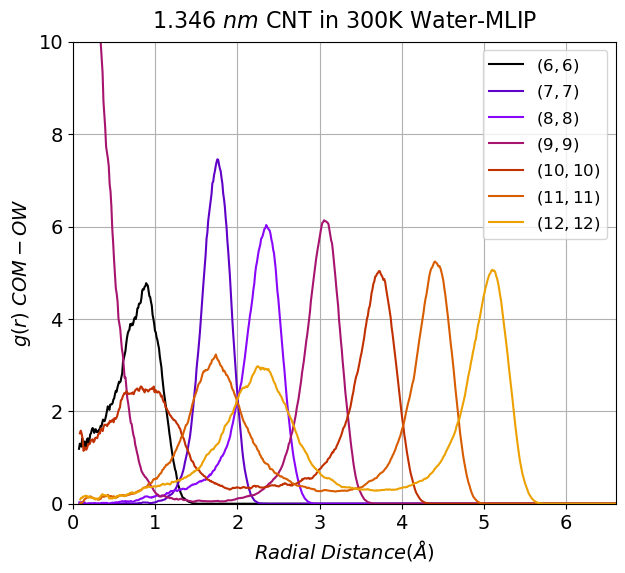

In [130]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

def compute_normalized_rdf(u):
    # 获取相关原子组
    o_atoms = u.select_atoms('type OT')
    cnt_c_atoms = u.select_atoms('resname CNT and name C')

    # 计算CNT C原子的z坐标平均值
    z_mean = cnt_c_atoms.positions[:,2].mean()
    cnt_up_h_atoms = u.select_atoms(f'resname CNT and name H and prop z > {z_mean}')
    cnt_down_h_atoms = u.select_atoms(f'resname CNT and name H and prop z <= {z_mean}')

    # 计算上下两组H原子的z坐标平均值并做微调
    z_up = cnt_up_h_atoms.positions[:,2].mean() - 2
    z_down = cnt_down_h_atoms.positions[:,2].mean() + 2

    # 初始化用于计算rho_0的变量
    total_o_atoms_outside = 0
    total_volume_outside = 0
    radius_reference = 15.5

    # 随机选择100帧
    num_frames = len(u.trajectory)
    selected_frames = random.sample(range(num_frames), 100)

    for frame_index in selected_frames:
        ts = u.trajectory[frame_index]

        # 获取当前帧的氧原子位置
        o_positions = o_atoms.positions
        cog = (cnt_up_h_atoms.center_of_geometry() + cnt_down_h_atoms.center_of_geometry()) / 2
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 计算大于radius_reference处的原子的数量
        mask_outside = distances > radius_reference
        total_o_atoms_outside += np.sum(mask_outside)

        # 计算大于radius_reference处的体积
        total_volume_outside += (u.dimensions[0] * u.dimensions[1] * (u.dimensions[2] - 2*radius_reference))

    # 计算rho_0 (3D)
    rho_0 = total_o_atoms_outside / total_volume_outside

    # 初始化径向分布函数的数组和相关参数
    n_bins = 2000
    radial_max = min(u.dimensions[0]/2, u.dimensions[1]/2)
    bin_edges = np.linspace(0, radial_max, n_bins+1)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[:-1] + bin_width / 2
    rdf_sum = np.zeros(n_bins)
    frames_counted = 0

    for ts in u.trajectory[1:3000]:
        # 对于每一帧计算rdf
        o_positions = o_atoms.positions
        z_o_positions = o_positions[:, 2]
        mask = (z_o_positions > z_down) & (z_o_positions < z_up)
        o_positions = o_positions[mask]
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 使用np.histogram()来计算这一帧的rdf
        counts, _ = np.histogram(distances, bins=bin_edges, density=False)

        # 累加
        rdf_sum += counts
        frames_counted += 1

    # 重新计算理想情况下的原子数
    ideal_counts = 2 * np.pi * bin_centers * bin_width * rho_0
    rdf_mean = rdf_sum / (frames_counted * ideal_counts)

    # 归一化RDF
    tail_fraction = 0.1
    tail_start = int((1 - tail_fraction) * len(rdf_mean))
    tail_mean = np.mean(rdf_mean[tail_start:])
    rdf_normalized = rdf_mean / tail_mean

    return bin_centers, rdf_normalized

# 使用示例：
# 你可以传入多个`u`对象，如u1, u2等，然后使用以下代码绘制在同一张图上
u_list = [u1_2,u1_7,u1_12,u1_17,u1_22, u1_27,u1_32]  # 可以添加更多的u对象，例如: [u1, u2, u3,...]



def moving_average(data, window_size=10):
    """返回数据的滚动平均值。"""
    series = pd.Series(data)
    return series.rolling(window=window_size).mean().values

def plot_rdf(u_list, labels=None):
    """
    为每一个u对象绘制RDF图
    u_list: 包含u对象的列表
    labels: 与u_list相对应的标签列表，用于图例
    """
    plt.figure(figsize=(7, 6))
    
    # 获取color_map
    color_map = cm.get_cmap('gnuplot',len(u_list)+1)
    
    for idx, u_obj in enumerate(u_list):
        bin_centers, rdf_normalized = compute_normalized_rdf(u_obj)
        rdf_smooth = moving_average(rdf_normalized, window_size=8)  # 这里设置窗口大小为50，你可以根据需求进行调整
        
        # 为每条曲线选择颜色
        color = color_map(idx)
        
        # 使用给定的标签或默认标签
        if labels:
            label = labels[idx]
        else:
            label = f"RDF for {u_obj}"
        
        plt.plot(bin_centers, rdf_smooth, '-', color=color, label=label)

    plt.xlabel("$Radial\ Distance (\AA)$", fontsize=14)
    plt.ylabel("$g(r)\ COM-OW$", fontsize=14)
    plt.title("1.346 $nm$ CNT in 300K Water-MLIP", fontsize=16,pad=10)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0,6.6)
    plt.ylim(0, 10)
    plt.yticks


labels = ["$(6, 6)$", "$(7, 7)$", "$(8, 8)$", "$(9, 9)$", "$(10, 10)$", "$(11, 11)$", "$(12, 12)$"]
plot_rdf(u_list, labels=labels)
plt.savefig("Z-Ow-in-6-12-6-fixed-MLIP.svg", format="svg", transparent=True)

/tmp/ipykernel_74996/813730328.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('gnuplot',len(u_list)+1)


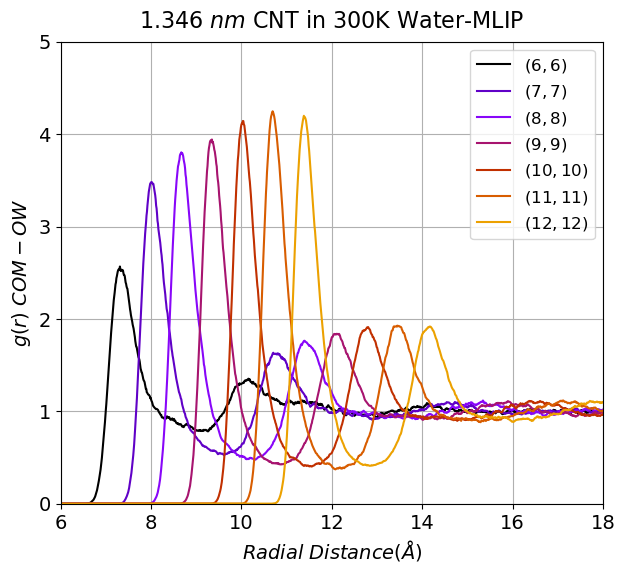

In [178]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

def compute_normalized_rdf(u):
    # 获取相关原子组
    o_atoms = u.select_atoms('type OT')
    cnt_c_atoms = u.select_atoms('resname CNT and name C')

    # 计算CNT C原子的z坐标平均值
    z_mean = cnt_c_atoms.positions[:,2].mean()
    cnt_up_h_atoms = u.select_atoms(f'resname CNT and name H and prop z > {z_mean}')
    cnt_down_h_atoms = u.select_atoms(f'resname CNT and name H and prop z <= {z_mean}')

    # 计算上下两组H原子的z坐标平均值并做微调
    z_up = cnt_up_h_atoms.positions[:,2].mean() - 2
    z_down = cnt_down_h_atoms.positions[:,2].mean() + 2

    # 初始化用于计算rho_0的变量
    total_o_atoms_outside = 0
    total_volume_outside = 0
    radius_reference = 15.5

    # 随机选择100帧
    num_frames = len(u.trajectory)
    selected_frames = random.sample(range(num_frames), 100)

    for frame_index in selected_frames:
        ts = u.trajectory[frame_index]

        # 获取当前帧的氧原子位置
        o_positions = o_atoms.positions
        cog = (cnt_up_h_atoms.center_of_geometry() + cnt_down_h_atoms.center_of_geometry()) / 2
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 计算大于radius_reference处的原子的数量
        mask_outside = distances > radius_reference
        total_o_atoms_outside += np.sum(mask_outside)

        # 计算大于radius_reference处的体积
        total_volume_outside += (u.dimensions[0] * u.dimensions[1] * (u.dimensions[2] - 2*radius_reference))

    # 计算rho_0 (3D)
    rho_0 = total_o_atoms_outside / total_volume_outside

    # 初始化径向分布函数的数组和相关参数
    n_bins = 2000
    radial_max = min(u.dimensions[0]/2, u.dimensions[1]/2)
    bin_edges = np.linspace(0, radial_max, n_bins+1)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[:-1] + bin_width / 2
    rdf_sum = np.zeros(n_bins)
    frames_counted = 0

    for ts in u.trajectory[1:3000]:
        # 对于每一帧计算rdf
        o_positions = o_atoms.positions
        z_o_positions = o_positions[:, 2]
        mask = (z_o_positions > z_down) & (z_o_positions < z_up)
        o_positions = o_positions[mask]
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 使用np.histogram()来计算这一帧的rdf
        counts, _ = np.histogram(distances, bins=bin_edges, density=False)

        # 累加
        rdf_sum += counts
        frames_counted += 1

    # 重新计算理想情况下的原子数
    ideal_counts = 2 * np.pi * bin_centers * bin_width * rho_0
    rdf_mean = rdf_sum / (frames_counted * ideal_counts)

    # 归一化RDF
    tail_fraction = 0.1
    tail_start = int((1 - tail_fraction) * len(rdf_mean))
    tail_mean = np.mean(rdf_mean[tail_start:])
    rdf_normalized = rdf_mean / tail_mean

    return bin_centers, rdf_normalized

# 使用示例：
# 你可以传入多个`u`对象，如u1, u2等，然后使用以下代码绘制在同一张图上
u_list = [u1_2,u1_7,u1_12,u1_17,u1_22, u1_27,u1_32]  # 可以添加更多的u对象，例如: [u1, u2, u3,...]



def moving_average(data, window_size=10):
    """返回数据的滚动平均值。"""
    series = pd.Series(data)
    return series.rolling(window=window_size).mean().values

def plot_rdf(u_list, labels=None):
    """
    为每一个u对象绘制RDF图
    u_list: 包含u对象的列表
    labels: 与u_list相对应的标签列表，用于图例
    """
    plt.figure(figsize=(7, 6))
    
    # 获取color_map
    color_map = cm.get_cmap('gnuplot',len(u_list)+1)
    
    for idx, u_obj in enumerate(u_list):
        bin_centers, rdf_normalized = compute_normalized_rdf(u_obj)
        rdf_smooth = moving_average(rdf_normalized, window_size=9)  # 这里设置窗口大小为50，你可以根据需求进行调整
        
        # 为每条曲线选择颜色
        color = color_map(idx)
        
        # 使用给定的标签或默认标签
        if labels:
            label = labels[idx]
        else:
            label = f"RDF for {u_obj}"
        
        plt.plot(bin_centers, rdf_smooth, '-', color=color, label=label)

    plt.xlabel("$Radial\ Distance (\AA)$", fontsize=14)
    plt.ylabel("$g(r)\ COM-OW$", fontsize=14)
    plt.title("1.346 $nm$ CNT in 300K Water-MLIP", fontsize=16,pad=10)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(6, 18)
    plt.ylim(0, 5)
    plt.yticks


labels = ["$(6, 6)$", "$(7, 7)$", "$(8, 8)$", "$(9, 9)$", "$(10, 10)$", "$(11, 11)$", "$(12, 12)$"]
plot_rdf(u_list, labels=labels)
plt.savefig("Z-Ow-out-6-12-6-fixed-MLIP.svg", format="svg", transparent=True)

/tmp/ipykernel_74996/831826500.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('gnuplot',len(u_list)+1)


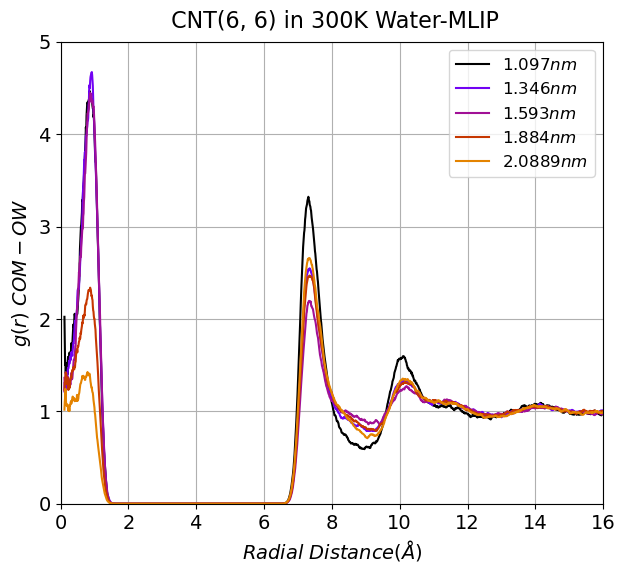

In [136]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

def compute_normalized_rdf(u):
    # 获取相关原子组
    o_atoms = u.select_atoms('type OT')
    cnt_c_atoms = u.select_atoms('resname CNT and name C')

    # 计算CNT C原子的z坐标平均值
    z_mean = cnt_c_atoms.positions[:,2].mean()
    cnt_up_h_atoms = u.select_atoms(f'resname CNT and name H and prop z > {z_mean}')
    cnt_down_h_atoms = u.select_atoms(f'resname CNT and name H and prop z <= {z_mean}')

    # 计算上下两组H原子的z坐标平均值并做微调
    z_up = cnt_up_h_atoms.positions[:,2].mean() - 2
    z_down = cnt_down_h_atoms.positions[:,2].mean() + 2

    # 初始化用于计算rho_0的变量
    total_o_atoms_outside = 0
    total_volume_outside = 0
    radius_reference = 15.5

    # 随机选择100帧
    num_frames = len(u.trajectory)
    selected_frames = random.sample(range(num_frames), 100)

    for frame_index in selected_frames:
        ts = u.trajectory[frame_index]

        # 获取当前帧的氧原子位置
        o_positions = o_atoms.positions
        cog = (cnt_up_h_atoms.center_of_geometry() + cnt_down_h_atoms.center_of_geometry()) / 2
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 计算大于radius_reference处的原子的数量
        mask_outside = distances > radius_reference
        total_o_atoms_outside += np.sum(mask_outside)

        # 计算大于radius_reference处的体积
        total_volume_outside += (u.dimensions[0] * u.dimensions[1] * (u.dimensions[2] - 2*radius_reference))

    # 计算rho_0 (3D)
    rho_0 = total_o_atoms_outside / total_volume_outside

    # 初始化径向分布函数的数组和相关参数
    n_bins = 2000
    radial_max = min(u.dimensions[0]/2, u.dimensions[1]/2)
    bin_edges = np.linspace(0, radial_max, n_bins+1)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[:-1] + bin_width / 2
    rdf_sum = np.zeros(n_bins)
    frames_counted = 0

    for ts in u.trajectory[1:3000]:
        # 对于每一帧计算rdf
        o_positions = o_atoms.positions
        z_o_positions = o_positions[:, 2]
        mask = (z_o_positions > z_down) & (z_o_positions < z_up)
        o_positions = o_positions[mask]
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 使用np.histogram()来计算这一帧的rdf
        counts, _ = np.histogram(distances, bins=bin_edges, density=False)

        # 累加
        rdf_sum += counts
        frames_counted += 1

    # 重新计算理想情况下的原子数
    ideal_counts = 2 * np.pi * bin_centers * bin_width * rho_0
    rdf_mean = rdf_sum / (frames_counted * ideal_counts)

    # 归一化RDF
    tail_fraction = 0.1
    tail_start = int((1 - tail_fraction) * len(rdf_mean))
    tail_mean = np.mean(rdf_mean[tail_start:])
    rdf_normalized = rdf_mean / tail_mean

    return bin_centers, rdf_normalized

# 使用示例：
# 你可以传入多个`u`对象，如u1, u2等，然后使用以下代码绘制在同一张图上
u_list = [u1_1,u1_2,u1_3,u1_4,u1_5]  # 可以添加更多的u对象，例如: [u1, u2, u3,...]



def moving_average(data, window_size=10):
    """返回数据的滚动平均值。"""
    series = pd.Series(data)
    return series.rolling(window=window_size).mean().values

def plot_rdf(u_list, labels=None):
    """
    为每一个u对象绘制RDF图
    u_list: 包含u对象的列表
    labels: 与u_list相对应的标签列表，用于图例
    """
    plt.figure(figsize=(7, 6))
    
    # 获取color_map
    color_map = cm.get_cmap('gnuplot',len(u_list)+1)
    
    for idx, u_obj in enumerate(u_list):
        bin_centers, rdf_normalized = compute_normalized_rdf(u_obj)
        rdf_smooth = moving_average(rdf_normalized, window_size=12)  # 这里设置窗口大小为50，你可以根据需求进行调整
        
        # 为每条曲线选择颜色
        color = color_map(idx)
        
        # 使用给定的标签或默认标签
        if labels:
            label = labels[idx]
        else:
            label = f"RDF for {u_obj}"
        
        plt.plot(bin_centers, rdf_smooth, '-', color=color, label=label)

    plt.xlabel("$Radial\ Distance (\AA)$", fontsize=14)
    plt.ylabel("$g(r)\ COM-OW$", fontsize=14)
    plt.title(" CNT(6, 6) in 300K Water-MLIP", fontsize=16,pad=10)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0, 16)
    plt.ylim(0, 5)
    plt.yticks


labels = ["$1.097 nm$", "$1.346 nm$", "$1.593 nm$", "$1.884 nm$", "$2.0889 nm$"]
plot_rdf(u_list, labels=labels)
plt.savefig("Z-Ow-all-6-6-5-9-ixed-MLIP.svg", format="svg", transparent=True)

# amber

In [174]:
import MDAnalysis as mda

index = 1
for x in range(6, 7):  # x从6遍历到12
    for y in range(5, 10):  # y从5遍历到9
        trjtpr_var_name = f"trjtpr1_{index}"
        trjxtc_var_name = f"trjxtc1_{index}"
        ua_var_name = f"ua_{index}"

        trjtpr_path = f"/home/jxhe/works/dp-cnt/cnt-dpmd-data/lib-mass/amberspce-data/02_6-12-56789-amber/{x}-{x}-{y}/amber.data"
        trjxtc_path = f"/home/jxhe/works/dp-cnt/cnt-dpmd-data/lib-mass/amberspce-data/02_6-12-56789-amber/{x}-{x}-{y}/03_nvt.lammpstrj"

        # 动态为每一个mda.Universe对象创建一个变量
        globals()[ua_var_name] = mda.Universe(trjtpr_path, trjxtc_path, format="LAMMPSDUMP")

        # 打印信息
        print(f"{trjtpr_var_name} = '{trjtpr_path}'")
        print(f"{trjxtc_var_name} = '{trjxtc_path}'")
        print(f"{ua_var_name} = mda.Universe('{trjtpr_path}', '{trjxtc_path}')")
        print()

        index += 1


trjtpr1_1 = '/home/jxhe/works/dp-cnt/cnt-dpmd-data/lib-mass/amberspce-data/02_6-12-56789-amber/6-6-5/amber.data'
trjxtc1_1 = '/home/jxhe/works/dp-cnt/cnt-dpmd-data/lib-mass/amberspce-data/02_6-12-56789-amber/6-6-5/03_nvt.lammpstrj'
ua_1 = mda.Universe('/home/jxhe/works/dp-cnt/cnt-dpmd-data/lib-mass/amberspce-data/02_6-12-56789-amber/6-6-5/amber.data', '/home/jxhe/works/dp-cnt/cnt-dpmd-data/lib-mass/amberspce-data/02_6-12-56789-amber/6-6-5/03_nvt.lammpstrj')

trjtpr1_2 = '/home/jxhe/works/dp-cnt/cnt-dpmd-data/lib-mass/amberspce-data/02_6-12-56789-amber/6-6-6/amber.data'
trjxtc1_2 = '/home/jxhe/works/dp-cnt/cnt-dpmd-data/lib-mass/amberspce-data/02_6-12-56789-amber/6-6-6/03_nvt.lammpstrj'
ua_2 = mda.Universe('/home/jxhe/works/dp-cnt/cnt-dpmd-data/lib-mass/amberspce-data/02_6-12-56789-amber/6-6-6/amber.data', '/home/jxhe/works/dp-cnt/cnt-dpmd-data/lib-mass/amberspce-data/02_6-12-56789-amber/6-6-6/03_nvt.lammpstrj')

trjtpr1_3 = '/home/jxhe/works/dp-cnt/cnt-dpmd-data/lib-mass/amberspce-data

/tmp/ipykernel_74996/3334632330.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('gnuplot',len(u_list)+1)


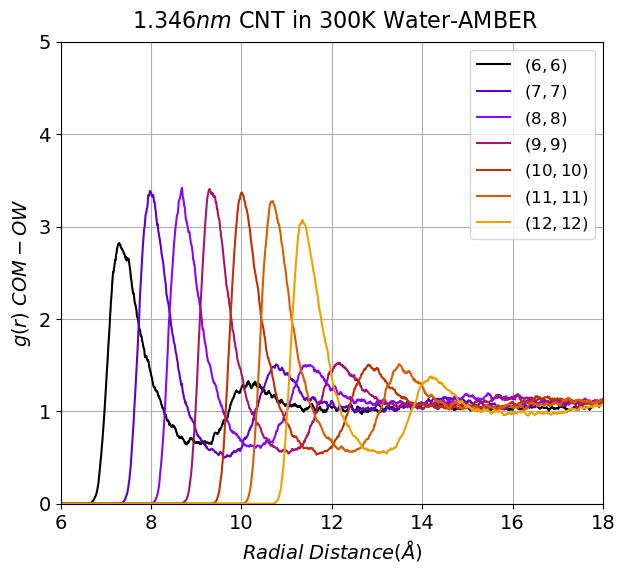

In [177]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

def compute_normalized_rdf(u):
    # 获取相关原子组
    o_atoms = u.select_atoms('type 4')
    cnt_c_atoms = u.select_atoms('type 1')

    # 计算CNT C原子的z坐标平均值
    z_mean = cnt_c_atoms.positions[:,2].mean()
    cnt_up_h_atoms = u.select_atoms(f'type 2 and prop z > {z_mean}')
    cnt_down_h_atoms = u.select_atoms(f'type 2 and prop z <= {z_mean}')

    # 计算上下两组H原子的z坐标平均值并做微调
    z_up = cnt_up_h_atoms.positions[:,2].mean() - 2
    z_down = cnt_down_h_atoms.positions[:,2].mean() + 2

    # 初始化用于计算rho_0的变量
    total_o_atoms_outside = 0
    total_volume_outside = 0
    radius_reference = 15.5

    # 随机选择100帧
    num_frames = len(u.trajectory)
    selected_frames = random.sample(range(num_frames), 100)

    for frame_index in selected_frames:
        ts = u.trajectory[frame_index]

        # 获取当前帧的氧原子位置
        o_positions = o_atoms.positions
        cog = (cnt_up_h_atoms.center_of_geometry() + cnt_down_h_atoms.center_of_geometry()) / 2
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 计算大于radius_reference处的原子的数量
        mask_outside = distances > radius_reference
        total_o_atoms_outside += np.sum(mask_outside)

        # 计算大于radius_reference处的体积
        total_volume_outside += (u.dimensions[0] * u.dimensions[1] * (u.dimensions[2] - 2*radius_reference))

    # 计算rho_0 (3D)
    rho_0 = total_o_atoms_outside / total_volume_outside

    # 初始化径向分布函数的数组和相关参数
    n_bins = 2000
    radial_max = min(u.dimensions[0]/2, u.dimensions[1]/2)
    bin_edges = np.linspace(0, radial_max, n_bins+1)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[:-1] + bin_width / 2
    rdf_sum = np.zeros(n_bins)
    frames_counted = 0

    for ts in u.trajectory[1:1523]:
        # 对于每一帧计算rdf
        o_positions = o_atoms.positions
        z_o_positions = o_positions[:, 2]
        mask = (z_o_positions > z_down) & (z_o_positions < z_up)
        o_positions = o_positions[mask]
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 使用np.histogram()来计算这一帧的rdf
        counts, _ = np.histogram(distances, bins=bin_edges, density=False)

        # 累加
        rdf_sum += counts
        frames_counted += 1

    # 重新计算理想情况下的原子数
    ideal_counts = 2 * np.pi * bin_centers * bin_width * rho_0
    rdf_mean = rdf_sum / (frames_counted * ideal_counts)

    # 归一化RDF
    tail_fraction = 0.1
    tail_start = int((1 - tail_fraction) * len(rdf_mean))
    tail_mean = np.mean(rdf_mean[tail_start:])
    rdf_normalized = rdf_mean / tail_mean

    return bin_centers, rdf_normalized

# 使用示例：
# 你可以传入多个`u`对象，如u1, u2等，然后使用以下代码绘制在同一张图上
u_list = [ua_2,ua_7,ua_12,ua_17,ua_22,ua_27,ua_32]  # 可以添加更多的u对象，例如: [u1, u2, u3,...]



def moving_average(data, window_size=10):
    """返回数据的滚动平均值。"""
    series = pd.Series(data)
    return series.rolling(window=window_size).mean().values

def plot_rdf(u_list, labels=None):
    """
    为每一个u对象绘制RDF图
    u_list: 包含u对象的列表
    labels: 与u_list相对应的标签列表，用于图例
    """
    plt.figure(figsize=(7, 6))
    
    # 获取color_map
    color_map = cm.get_cmap('gnuplot',len(u_list)+1)
    
    for idx, u_obj in enumerate(u_list):
        bin_centers, rdf_normalized = compute_normalized_rdf(u_obj)
        rdf_smooth = moving_average(rdf_normalized, window_size=8)  # 这里设置窗口大小为50，你可以根据需求进行调整
        
        # 为每条曲线选择颜色
        color = color_map(idx)
        
        # 使用给定的标签或默认标签
        if labels:
            label = labels[idx]
        else:
            label = f"RDF for {u_obj}"
        
        plt.plot(bin_centers, rdf_smooth, '-', color=color, label=label)

    plt.xlabel("$Radial\ Distance (\AA)$", fontsize=14)
    plt.ylabel("$g(r)\ COM-OW$", fontsize=14)
    plt.title(" $1.346 nm$ CNT in 300K Water-AMBER", fontsize=16,pad=10)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(6,18)
    plt.ylim(0, 5)
    plt.yticks


labels = ["$(6, 6)$","$(7, 7)$", "$(8, 8)$", "$(9, 9)$", "$(10, 10)$", "$(11, 11)$", "$(12, 12)$"]
plot_rdf(u_list, labels=labels)
plt.savefig("Z-Ow-in-6-12-18r-ab.svg", format="svg", transparent=True)

/tmp/ipykernel_74996/3641802091.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('gnuplot',len(u_list)+1)


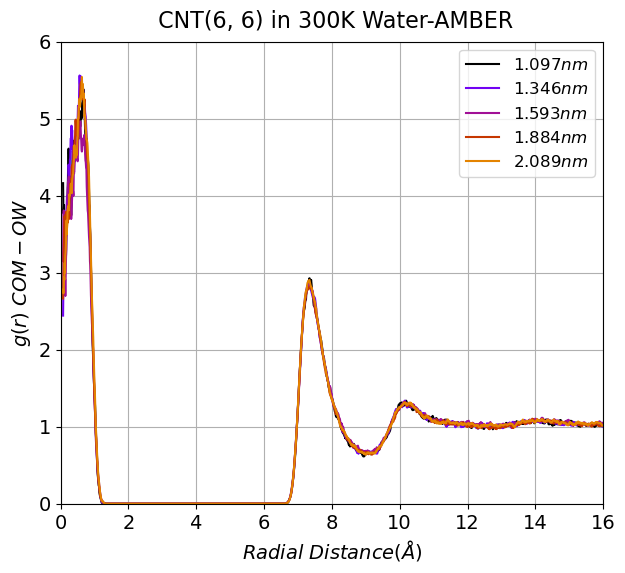

In [169]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

def compute_normalized_rdf(u):
    # 获取相关原子组
    o_atoms = u.select_atoms('type 4')
    cnt_c_atoms = u.select_atoms('type 1')

    # 计算CNT C原子的z坐标平均值
    z_mean = cnt_c_atoms.positions[:,2].mean()
    cnt_up_h_atoms = u.select_atoms(f'type 2 and prop z > {z_mean}')
    cnt_down_h_atoms = u.select_atoms(f'type 2 and prop z <= {z_mean}')

    # 计算上下两组H原子的z坐标平均值并做微调
    z_up = cnt_up_h_atoms.positions[:,2].mean() - 2
    z_down = cnt_down_h_atoms.positions[:,2].mean() + 2

    # 初始化用于计算rho_0的变量
    total_o_atoms_outside = 0
    total_volume_outside = 0
    radius_reference = 15.5

    # 随机选择100帧
    num_frames = len(u.trajectory)
    selected_frames = random.sample(range(num_frames), 100)

    for frame_index in selected_frames:
        ts = u.trajectory[frame_index]

        # 获取当前帧的氧原子位置
        o_positions = o_atoms.positions
        cog = (cnt_up_h_atoms.center_of_geometry() + cnt_down_h_atoms.center_of_geometry()) / 2
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 计算大于radius_reference处的原子的数量
        mask_outside = distances > radius_reference
        total_o_atoms_outside += np.sum(mask_outside)

        # 计算大于radius_reference处的体积
        total_volume_outside += (u.dimensions[0] * u.dimensions[1] * (u.dimensions[2] - 2*radius_reference))

    # 计算rho_0 (3D)
    rho_0 = total_o_atoms_outside / total_volume_outside

    # 初始化径向分布函数的数组和相关参数
    n_bins = 2000
    radial_max = min(u.dimensions[0]/2, u.dimensions[1]/2)
    bin_edges = np.linspace(0, radial_max, n_bins+1)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[:-1] + bin_width / 2
    rdf_sum = np.zeros(n_bins)
    frames_counted = 0

    for ts in u.trajectory[1:2000]:
        # 对于每一帧计算rdf
        o_positions = o_atoms.positions
        z_o_positions = o_positions[:, 2]
        mask = (z_o_positions > z_down) & (z_o_positions < z_up)
        o_positions = o_positions[mask]
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 使用np.histogram()来计算这一帧的rdf
        counts, _ = np.histogram(distances, bins=bin_edges, density=False)

        # 累加
        rdf_sum += counts
        frames_counted += 1

    # 重新计算理想情况下的原子数
    ideal_counts = 2 * np.pi * bin_centers * bin_width * rho_0
    rdf_mean = rdf_sum / (frames_counted * ideal_counts)

    # 归一化RDF
    tail_fraction = 0.1
    tail_start = int((1 - tail_fraction) * len(rdf_mean))
    tail_mean = np.mean(rdf_mean[tail_start:])
    rdf_normalized = rdf_mean / tail_mean

    return bin_centers, rdf_normalized

# 使用示例：
# 你可以传入多个`u`对象，如u1, u2等，然后使用以下代码绘制在同一张图上
u_list = [ua_1,ua_2,ua_3,ua_4,ua_5]  # 可以添加更多的u对象，例如: [u1, u2, u3,...]



def moving_average(data, window_size=10):
    """返回数据的滚动平均值。"""
    series = pd.Series(data)
    return series.rolling(window=window_size).mean().values

def plot_rdf(u_list, labels=None):
    """
    为每一个u对象绘制RDF图
    u_list: 包含u对象的列表
    labels: 与u_list相对应的标签列表，用于图例
    """
    plt.figure(figsize=(7, 6))
    
    # 获取color_map
    color_map = cm.get_cmap('gnuplot',len(u_list)+1)
    
    for idx, u_obj in enumerate(u_list):
        bin_centers, rdf_normalized = compute_normalized_rdf(u_obj)
        rdf_smooth = moving_average(rdf_normalized, window_size=8)  # 这里设置窗口大小为50，你可以根据需求进行调整
        
        # 为每条曲线选择颜色
        color = color_map(idx)
        
        # 使用给定的标签或默认标签
        if labels:
            label = labels[idx]
        else:
            label = f"RDF for {u_obj}"
        
        plt.plot(bin_centers, rdf_smooth, '-', color=color, label=label)

    plt.xlabel("$Radial\ Distance (\AA)$", fontsize=14)
    plt.ylabel("$g(r)\ COM-OW$", fontsize=14)
    plt.title(" CNT(6, 6) in 300K Water-AMBER", fontsize=16,pad=10)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0,16)
    plt.ylim(0, 6)
    plt.yticks


labels = ["$1.097 nm$", "$1.346 nm$", "$1.593 nm$", "$1.884 nm$", "$2.089 nm$"]
plot_rdf(u_list, labels=labels)
plt.savefig("Z-Ow-in-6-6-5-9-fixed-AMBER.svg", format="svg", transparent=True)

# free

In [146]:
for y in ["fixed","free"]:  # y从5遍历到9
    print(f"{y}-1")

fixed-1
free-1


In [148]:
import MDAnalysis as mda

index = 1
for x in range(6, 13):  # x从6遍历到12
    for y in ["fixed","free"]:  # y从5遍历到9
        trjtpr_var_name = f"trjtpr1_{index}"
        trjxtc_var_name = f"trjxtc1_{index}"
        u2_var_name = f"u2_{index}"

        trjtpr_path = f"/home/jxhe/works/toolkits/03-fixfreedp-6-12-19/{x}-{x}-19-{y}-npt/cnt.tpr"
        trjxtc_path = f"/home/jxhe/works/toolkits/03-fixfreedp-6-12-19/{x}-{x}-19-{y}-npt/{x}-{x}-19-{y}-npt.xtc"

        # 动态为每一个mda.Universe对象创建一个变量
        globals()[u2_var_name] = mda.Universe(trjtpr_path, trjxtc_path)

        # 打印信息
        print(f"{trjtpr_var_name} = '{trjtpr_path}'")
        print(f"{trjxtc_var_name} = '{trjxtc_path}'")
        print(f"{u2_var_name} = mda.Universe('{trjtpr_path}', '{trjxtc_path}')")
        print()

        index += 1


trjtpr1_1 = '/home/jxhe/works/toolkits/03-fixfreedp-6-12-19/6-6-19-fixed-npt/cnt.tpr'
trjxtc1_1 = '/home/jxhe/works/toolkits/03-fixfreedp-6-12-19/6-6-19-fixed-npt/6-6-19-fixed-npt.xtc'
u2_1 = mda.Universe('/home/jxhe/works/toolkits/03-fixfreedp-6-12-19/6-6-19-fixed-npt/cnt.tpr', '/home/jxhe/works/toolkits/03-fixfreedp-6-12-19/6-6-19-fixed-npt/6-6-19-fixed-npt.xtc')

trjtpr1_2 = '/home/jxhe/works/toolkits/03-fixfreedp-6-12-19/6-6-19-free-npt/cnt.tpr'
trjxtc1_2 = '/home/jxhe/works/toolkits/03-fixfreedp-6-12-19/6-6-19-free-npt/6-6-19-free-npt.xtc'
u2_2 = mda.Universe('/home/jxhe/works/toolkits/03-fixfreedp-6-12-19/6-6-19-free-npt/cnt.tpr', '/home/jxhe/works/toolkits/03-fixfreedp-6-12-19/6-6-19-free-npt/6-6-19-free-npt.xtc')

trjtpr1_3 = '/home/jxhe/works/toolkits/03-fixfreedp-6-12-19/7-7-19-fixed-npt/cnt.tpr'
trjxtc1_3 = '/home/jxhe/works/toolkits/03-fixfreedp-6-12-19/7-7-19-fixed-npt/7-7-19-fixed-npt.xtc'
u2_3 = mda.Universe('/home/jxhe/works/toolkits/03-fixfreedp-6-12-19/7-7-19-fixed-np

/tmp/ipykernel_74996/856418700.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('gnuplot',len(u_list)+1)


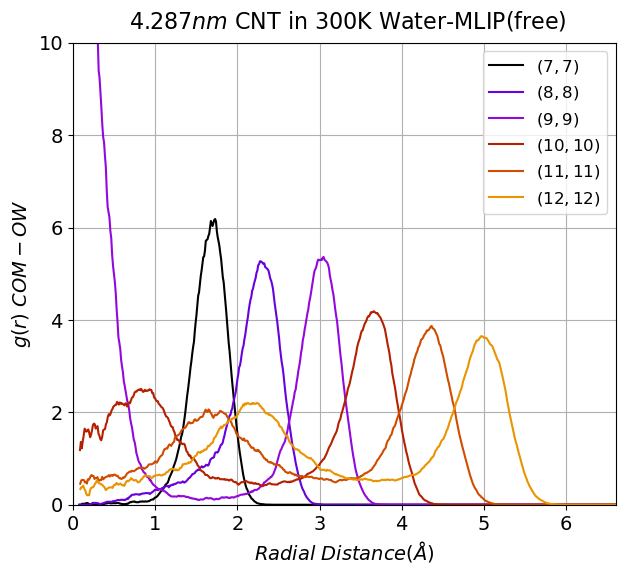

In [155]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

def compute_normalized_rdf(u):
    # 获取相关原子组
    o_atoms = u.select_atoms('type OT')
    cnt_c_atoms = u.select_atoms('resname CNT and name C')

    # 计算CNT C原子的z坐标平均值
    z_mean = cnt_c_atoms.positions[:,2].mean()
    cnt_up_h_atoms = u.select_atoms(f'resname CNT and name C and prop z > {z_mean}')
    cnt_down_h_atoms = u.select_atoms(f'resname CNT and name C and prop z <= {z_mean}')

    # 计算上下两组H原子的z坐标平均值并做微调
    z_up = cnt_up_h_atoms.positions[:,2].mean() - 2
    z_down = cnt_down_h_atoms.positions[:,2].mean() + 2

    # 初始化用于计算rho_0的变量
    total_o_atoms_outside = 0
    total_volume_outside = 0
    radius_reference = 15.5

    # 随机选择100帧
    num_frames = len(u.trajectory)
    selected_frames = random.sample(range(num_frames), 100)

    for frame_index in selected_frames:
        ts = u.trajectory[frame_index]

        # 获取当前帧的氧原子位置
        o_positions = o_atoms.positions
        cog = (cnt_up_h_atoms.center_of_geometry() + cnt_down_h_atoms.center_of_geometry()) / 2
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 计算大于radius_reference处的原子的数量
        mask_outside = distances > radius_reference
        total_o_atoms_outside += np.sum(mask_outside)

        # 计算大于radius_reference处的体积
        total_volume_outside += (u.dimensions[0] * u.dimensions[1] * (u.dimensions[2] - 2*radius_reference))

    # 计算rho_0 (3D)
    rho_0 = total_o_atoms_outside / total_volume_outside

    # 初始化径向分布函数的数组和相关参数
    n_bins = 2000
    radial_max = min(u.dimensions[0]/2, u.dimensions[1]/2)
    bin_edges = np.linspace(0, radial_max, n_bins+1)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[:-1] + bin_width / 2
    rdf_sum = np.zeros(n_bins)
    frames_counted = 0

    for ts in u.trajectory[1:1523]:
        # 对于每一帧计算rdf
        o_positions = o_atoms.positions
        z_o_positions = o_positions[:, 2]
        mask = (z_o_positions > z_down) & (z_o_positions < z_up)
        o_positions = o_positions[mask]
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 使用np.histogram()来计算这一帧的rdf
        counts, _ = np.histogram(distances, bins=bin_edges, density=False)

        # 累加
        rdf_sum += counts
        frames_counted += 1

    # 重新计算理想情况下的原子数
    ideal_counts = 2 * np.pi * bin_centers * bin_width * rho_0
    rdf_mean = rdf_sum / (frames_counted * ideal_counts)

    # 归一化RDF
    tail_fraction = 0.1
    tail_start = int((1 - tail_fraction) * len(rdf_mean))
    tail_mean = np.mean(rdf_mean[tail_start:])
    rdf_normalized = rdf_mean / tail_mean

    return bin_centers, rdf_normalized

# 使用示例：
# 你可以传入多个`u`对象，如u1, u2等，然后使用以下代码绘制在同一张图上
u_list = [u2_4,u2_6,u2_8,u2_10,u2_12,u2_14]  # 可以添加更多的u对象，例如: [u1, u2, u3,...]



def moving_average(data, window_size=10):
    """返回数据的滚动平均值。"""
    series = pd.Series(data)
    return series.rolling(window=window_size).mean().values

def plot_rdf(u_list, labels=None):
    """
    为每一个u对象绘制RDF图
    u_list: 包含u对象的列表
    labels: 与u_list相对应的标签列表，用于图例
    """
    plt.figure(figsize=(7, 6))
    
    # 获取color_map
    color_map = cm.get_cmap('gnuplot',len(u_list)+1)
    
    for idx, u_obj in enumerate(u_list):
        bin_centers, rdf_normalized = compute_normalized_rdf(u_obj)
        rdf_smooth = moving_average(rdf_normalized, window_size=8)  # 这里设置窗口大小为50，你可以根据需求进行调整
        
        # 为每条曲线选择颜色
        color = color_map(idx)
        
        # 使用给定的标签或默认标签
        if labels:
            label = labels[idx]
        else:
            label = f"RDF for {u_obj}"
        
        plt.plot(bin_centers, rdf_smooth, '-', color=color, label=label)

    plt.xlabel("$Radial\ Distance (\AA)$", fontsize=14)
    plt.ylabel("$g(r)\ COM-OW$", fontsize=14)
    plt.title(" $4.287 nm$ CNT in 300K Water-MLIP(free)", fontsize=16,pad=10)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0,6.6)
    plt.ylim(0, 10)
    plt.yticks


labels = ["$(7, 7)$", "$(8, 8)$", "$(9, 9)$", "$(10, 10)$", "$(11, 11)$", "$(12, 12)$"]
plot_rdf(u_list, labels=labels)
plt.savefig("Z-Ow-in-7-12-19-free-MLIP.svg", format="svg", transparent=True)

In [ ]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

def compute_normalized_rdf(u):
    # 获取相关原子组
    o_atoms = u.select_atoms('type OT')
    cnt_c_atoms = u.select_atoms('resname CNT and name C')

    # 计算CNT C原子的z坐标平均值
    z_mean = cnt_c_atoms.positions[:,2].mean()
    cnt_up_h_atoms = u.select_atoms(f'resname CNT and name C and prop z > {z_mean}')
    cnt_down_h_atoms = u.select_atoms(f'resname CNT and name C and prop z <= {z_mean}')

    # 计算上下两组H原子的z坐标平均值并做微调
    z_up = cnt_up_h_atoms.positions[:,2].mean() - 2
    z_down = cnt_down_h_atoms.positions[:,2].mean() + 2

    # 初始化用于计算rho_0的变量
    total_o_atoms_outside = 0
    total_volume_outside = 0
    radius_reference = 15.5

    # 随机选择100帧
    num_frames = len(u.trajectory)
    selected_frames = random.sample(range(num_frames), 100)

    for frame_index in selected_frames:
        ts = u.trajectory[frame_index]

        # 获取当前帧的氧原子位置
        o_positions = o_atoms.positions
        cog = (cnt_up_h_atoms.center_of_geometry() + cnt_down_h_atoms.center_of_geometry()) / 2
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 计算大于radius_reference处的原子的数量
        mask_outside = distances > radius_reference
        total_o_atoms_outside += np.sum(mask_outside)

        # 计算大于radius_reference处的体积
        total_volume_outside += (u.dimensions[0] * u.dimensions[1] * (u.dimensions[2] - 2*radius_reference))

    # 计算rho_0 (3D)
    rho_0 = total_o_atoms_outside / total_volume_outside

    # 初始化径向分布函数的数组和相关参数
    n_bins = 2000
    radial_max = min(u.dimensions[0]/2, u.dimensions[1]/2)
    bin_edges = np.linspace(0, radial_max, n_bins+1)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[:-1] + bin_width / 2
    rdf_sum = np.zeros(n_bins)
    frames_counted = 0

    for ts in u.trajectory[1:1523]:
        # 对于每一帧计算rdf
        o_positions = o_atoms.positions
        z_o_positions = o_positions[:, 2]
        mask = (z_o_positions > z_down) & (z_o_positions < z_up)
        o_positions = o_positions[mask]
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 使用np.histogram()来计算这一帧的rdf
        counts, _ = np.histogram(distances, bins=bin_edges, density=False)

        # 累加
        rdf_sum += counts
        frames_counted += 1

    # 重新计算理想情况下的原子数
    ideal_counts = 2 * np.pi * bin_centers * bin_width * rho_0
    rdf_mean = rdf_sum / (frames_counted * ideal_counts)

    # 归一化RDF
    tail_fraction = 0.1
    tail_start = int((1 - tail_fraction) * len(rdf_mean))
    tail_mean = np.mean(rdf_mean[tail_start:])
    rdf_normalized = rdf_mean / tail_mean

    return bin_centers, rdf_normalized

# 使用示例：
# 你可以传入多个`u`对象，如u1, u2等，然后使用以下代码绘制在同一张图上
u_list = [u2_4,u2_6,u2_8,u2_10,u2_12,u2_14]  # 可以添加更多的u对象，例如: [u1, u2, u3,...]



def moving_average(data, window_size=10):
    """返回数据的滚动平均值。"""
    series = pd.Series(data)
    return series.rolling(window=window_size).mean().values

def plot_rdf(u_list, labels=None):
    """
    为每一个u对象绘制RDF图
    u_list: 包含u对象的列表
    labels: 与u_list相对应的标签列表，用于图例
    """
    plt.figure(figsize=(7, 6))
    
    # 获取color_map
    color_map = cm.get_cmap('gnuplot',len(u_list)+1)
    
    for idx, u_obj in enumerate(u_list):
        bin_centers, rdf_normalized = compute_normalized_rdf(u_obj)
        rdf_smooth = moving_average(rdf_normalized, window_size=8)  # 这里设置窗口大小为50，你可以根据需求进行调整
        
        # 为每条曲线选择颜色
        color = color_map(idx)
        
        # 使用给定的标签或默认标签
        if labels:
            label = labels[idx]
        else:
            label = f"RDF for {u_obj}"
        
        plt.plot(bin_centers, rdf_smooth, '-', color=color, label=label)

    plt.xlabel("$Radial\ Distance (\AA)$", fontsize=14)
    plt.ylabel("$g(r)\ COM-OW$", fontsize=14)
    plt.title(" $4.287 nm$ CNT in 300K Water-MLIP(free)", fontsize=16,pad=10)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(6,18)
    plt.ylim(0, 5)
    plt.yticks


labels = ["$(7, 7)$", "$(8, 8)$", "$(9, 9)$", "$(10, 10)$", "$(11, 11)$", "$(12, 12)$"]
plot_rdf(u_list, labels=labels)
plt.savefig("Z-Ow-out-7-12-19-free-MLIP.svg", format="svg", transparent=True)

/tmp/ipykernel_74996/3686071627.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('gnuplot',len(u_list)+1)


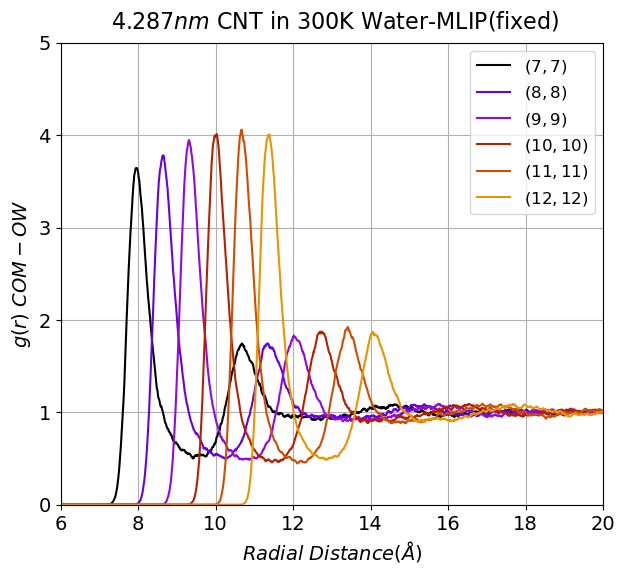

In [160]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

def compute_normalized_rdf(u):
    # 获取相关原子组
    o_atoms = u.select_atoms('type OT')
    cnt_c_atoms = u.select_atoms('resname CNT and name C')

    # 计算CNT C原子的z坐标平均值
    z_mean = cnt_c_atoms.positions[:,2].mean()
    cnt_up_h_atoms = u.select_atoms(f'resname CNT and name C and prop z > {z_mean}')
    cnt_down_h_atoms = u.select_atoms(f'resname CNT and name C and prop z <= {z_mean}')

    # 计算上下两组H原子的z坐标平均值并做微调
    z_up = cnt_up_h_atoms.positions[:,2].mean() - 2
    z_down = cnt_down_h_atoms.positions[:,2].mean() + 2

    # 初始化用于计算rho_0的变量
    total_o_atoms_outside = 0
    total_volume_outside = 0
    radius_reference = 15.5

    # 随机选择100帧
    num_frames = len(u.trajectory)
    selected_frames = random.sample(range(num_frames), 100)

    for frame_index in selected_frames:
        ts = u.trajectory[frame_index]

        # 获取当前帧的氧原子位置
        o_positions = o_atoms.positions
        cog = (cnt_up_h_atoms.center_of_geometry() + cnt_down_h_atoms.center_of_geometry()) / 2
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 计算大于radius_reference处的原子的数量
        mask_outside = distances > radius_reference
        total_o_atoms_outside += np.sum(mask_outside)

        # 计算大于radius_reference处的体积
        total_volume_outside += (u.dimensions[0] * u.dimensions[1] * (u.dimensions[2] - 2*radius_reference))

    # 计算rho_0 (3D)
    rho_0 = total_o_atoms_outside / total_volume_outside

    # 初始化径向分布函数的数组和相关参数
    n_bins = 2000
    radial_max = min(u.dimensions[0]/2, u.dimensions[1]/2)
    bin_edges = np.linspace(0, radial_max, n_bins+1)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[:-1] + bin_width / 2
    rdf_sum = np.zeros(n_bins)
    frames_counted = 0

    for ts in u.trajectory[1:1523]:
        # 对于每一帧计算rdf
        o_positions = o_atoms.positions
        z_o_positions = o_positions[:, 2]
        mask = (z_o_positions > z_down) & (z_o_positions < z_up)
        o_positions = o_positions[mask]
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 使用np.histogram()来计算这一帧的rdf
        counts, _ = np.histogram(distances, bins=bin_edges, density=False)

        # 累加
        rdf_sum += counts
        frames_counted += 1

    # 重新计算理想情况下的原子数
    ideal_counts = 2 * np.pi * bin_centers * bin_width * rho_0
    rdf_mean = rdf_sum / (frames_counted * ideal_counts)

    # 归一化RDF
    tail_fraction = 0.1
    tail_start = int((1 - tail_fraction) * len(rdf_mean))
    tail_mean = np.mean(rdf_mean[tail_start:])
    rdf_normalized = rdf_mean / tail_mean

    return bin_centers, rdf_normalized

# 使用示例：
# 你可以传入多个`u`对象，如u1, u2等，然后使用以下代码绘制在同一张图上
u_list = [u2_3,u2_5,u2_7,u2_9,u2_11,u2_13]  # 可以添加更多的u对象，例如: [u1, u2, u3,...]



def moving_average(data, window_size=10):
    """返回数据的滚动平均值。"""
    series = pd.Series(data)
    return series.rolling(window=window_size).mean().values

def plot_rdf(u_list, labels=None):
    """
    为每一个u对象绘制RDF图
    u_list: 包含u对象的列表
    labels: 与u_list相对应的标签列表，用于图例
    """
    plt.figure(figsize=(7, 6))
    
    # 获取color_map
    color_map = cm.get_cmap('gnuplot',len(u_list)+1)
    
    for idx, u_obj in enumerate(u_list):
        bin_centers, rdf_normalized = compute_normalized_rdf(u_obj)
        rdf_smooth = moving_average(rdf_normalized, window_size=8)  # 这里设置窗口大小为50，你可以根据需求进行调整
        
        # 为每条曲线选择颜色
        color = color_map(idx)
        
        # 使用给定的标签或默认标签
        if labels:
            label = labels[idx]
        else:
            label = f"RDF for {u_obj}"
        
        plt.plot(bin_centers, rdf_smooth, '-', color=color, label=label)

    plt.xlabel("$Radial\ Distance (\AA)$", fontsize=14)
    plt.ylabel("$g(r)\ COM-OW$", fontsize=14)
    plt.title(" $4.287 nm$ CNT in 300K Water-MLIP(fixed)", fontsize=16,pad=10)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(6,20)
    plt.ylim(0, 5)
    plt.yticks


labels = ["$(7, 7)$", "$(8, 8)$", "$(9, 9)$", "$(10, 10)$", "$(11, 11)$", "$(12, 12)$"]
plot_rdf(u_list, labels=labels)
plt.savefig("Z-Ow-out-7-12-19-fixed-MLIP.svg", format="svg", transparent=True)

/tmp/ipykernel_74996/2098086235.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('gnuplot',len(u_list)+1)


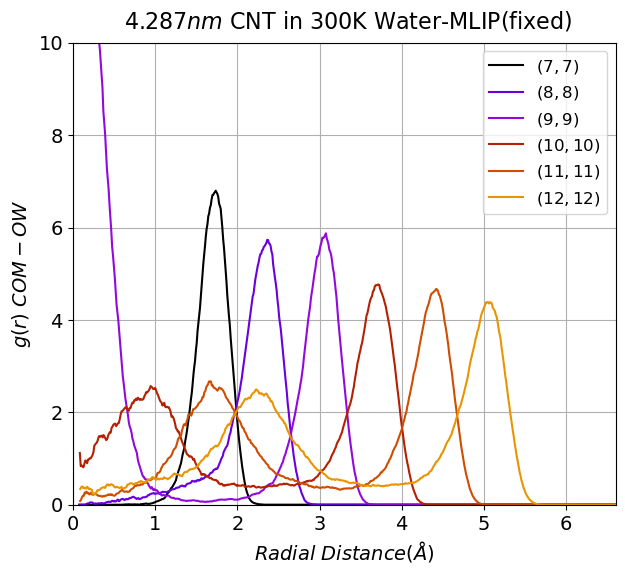

In [159]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

def compute_normalized_rdf(u):
    # 获取相关原子组
    o_atoms = u.select_atoms('type OT')
    cnt_c_atoms = u.select_atoms('resname CNT and name C')

    # 计算CNT C原子的z坐标平均值
    z_mean = cnt_c_atoms.positions[:,2].mean()
    cnt_up_h_atoms = u.select_atoms(f'resname CNT and name C and prop z > {z_mean}')
    cnt_down_h_atoms = u.select_atoms(f'resname CNT and name C and prop z <= {z_mean}')

    # 计算上下两组H原子的z坐标平均值并做微调
    z_up = cnt_up_h_atoms.positions[:,2].mean() - 2
    z_down = cnt_down_h_atoms.positions[:,2].mean() + 2

    # 初始化用于计算rho_0的变量
    total_o_atoms_outside = 0
    total_volume_outside = 0
    radius_reference = 15.5

    # 随机选择100帧
    num_frames = len(u.trajectory)
    selected_frames = random.sample(range(num_frames), 100)

    for frame_index in selected_frames:
        ts = u.trajectory[frame_index]

        # 获取当前帧的氧原子位置
        o_positions = o_atoms.positions
        cog = (cnt_up_h_atoms.center_of_geometry() + cnt_down_h_atoms.center_of_geometry()) / 2
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 计算大于radius_reference处的原子的数量
        mask_outside = distances > radius_reference
        total_o_atoms_outside += np.sum(mask_outside)

        # 计算大于radius_reference处的体积
        total_volume_outside += (u.dimensions[0] * u.dimensions[1] * (u.dimensions[2] - 2*radius_reference))

    # 计算rho_0 (3D)
    rho_0 = total_o_atoms_outside / total_volume_outside

    # 初始化径向分布函数的数组和相关参数
    n_bins = 2000
    radial_max = min(u.dimensions[0]/2, u.dimensions[1]/2)
    bin_edges = np.linspace(0, radial_max, n_bins+1)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[:-1] + bin_width / 2
    rdf_sum = np.zeros(n_bins)
    frames_counted = 0

    for ts in u.trajectory[1:1523]:
        # 对于每一帧计算rdf
        o_positions = o_atoms.positions
        z_o_positions = o_positions[:, 2]
        mask = (z_o_positions > z_down) & (z_o_positions < z_up)
        o_positions = o_positions[mask]
        distances = np.linalg.norm(o_positions[:, :2] - cog[:2], axis=1)

        # 使用np.histogram()来计算这一帧的rdf
        counts, _ = np.histogram(distances, bins=bin_edges, density=False)

        # 累加
        rdf_sum += counts
        frames_counted += 1

    # 重新计算理想情况下的原子数
    ideal_counts = 2 * np.pi * bin_centers * bin_width * rho_0
    rdf_mean = rdf_sum / (frames_counted * ideal_counts)

    # 归一化RDF
    tail_fraction = 0.1
    tail_start = int((1 - tail_fraction) * len(rdf_mean))
    tail_mean = np.mean(rdf_mean[tail_start:])
    rdf_normalized = rdf_mean / tail_mean

    return bin_centers, rdf_normalized

# 使用示例：
# 你可以传入多个`u`对象，如u1, u2等，然后使用以下代码绘制在同一张图上
u_list = [u2_3,u2_5,u2_7,u2_9,u2_11,u2_13]  # 可以添加更多的u对象，例如: [u1, u2, u3,...]



def moving_average(data, window_size=10):
    """返回数据的滚动平均值。"""
    series = pd.Series(data)
    return series.rolling(window=window_size).mean().values

def plot_rdf(u_list, labels=None):
    """
    为每一个u对象绘制RDF图
    u_list: 包含u对象的列表
    labels: 与u_list相对应的标签列表，用于图例
    """
    plt.figure(figsize=(7, 6))
    
    # 获取color_map
    color_map = cm.get_cmap('gnuplot',len(u_list)+1)
    
    for idx, u_obj in enumerate(u_list):
        bin_centers, rdf_normalized = compute_normalized_rdf(u_obj)
        rdf_smooth = moving_average(rdf_normalized, window_size=8)  # 这里设置窗口大小为50，你可以根据需求进行调整
        
        # 为每条曲线选择颜色
        color = color_map(idx)
        
        # 使用给定的标签或默认标签
        if labels:
            label = labels[idx]
        else:
            label = f"RDF for {u_obj}"
        
        plt.plot(bin_centers, rdf_smooth, '-', color=color, label=label)

    plt.xlabel("$Radial\ Distance (\AA)$", fontsize=14)
    plt.ylabel("$g(r)\ COM-OW$", fontsize=14)
    plt.title(" $4.287 nm$ CNT in 300K Water-MLIP(fixed)", fontsize=16,pad=10)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0,6.6)
    plt.ylim(0, 10)
    plt.yticks


labels = ["$(7, 7)$", "$(8, 8)$", "$(9, 9)$", "$(10, 10)$", "$(11, 11)$", "$(12, 12)$"]
plot_rdf(u_list, labels=labels)
plt.savefig("Z-Ow-in-7-12-19-fixed-MLIP.svg", format="svg", transparent=True)